<a href="https://colab.research.google.com/github/SJKIM2253/Statistics_with_Python/blob/master/B%EB%B0%98_4%EC%A1%B0_%EA%B9%80%EC%88%98%EC%A7%84_%EA%B7%B8%EB%9E%98%EB%94%94%EC%96%B8%ED%8A%B8_%EB%B6%80%EC%8A%A4%ED%8C%85_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 콘크리트 강도를 예측하는 그래디언트 부스팅 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라. 
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
 -.목표변수(Concrete_compressive_strength)
 
※ 데이터는 ( train(0.4) : validation(0.3) : validation(0.3) )의 비율로 분할 (train_validation_split 활용)
 0. train_validation_split 함수를 이용하여 train:validation로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
 1. train 데이터: 모델 훈련 
 2. validation 데이터: 최적의 parameter 찾기(과정의 [연습/실습]에서 validation 데이터 역할)
 3. validation 데이터: 2에서 찾은 최적의 parameter를 이용하여 만든 모델로 최종 성능 확인(단 한 번만 사용할 것)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 새 섹션

In [89]:
pip install graphviz

In [90]:
#Concrete.csv을 불러옴
df_raw = pd.read_csv("/content/drive/My Drive/BigDataAnalysis/Concrete.csv", engine = "python")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [91]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis= 1, inplace = False)

# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, validation_size=validation 데이터 비율, random_state: random seed)
# train_set_split 함수를 이용하여 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할
# train_set_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
#random state=8로 지정하여 입력 데이터 고정df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=8)
df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=87)
df_validation_x, df_test_x, df_validation_y, df_test_y= train_test_split(df_rest_x, df_rest_y, test_size=0.5, random_state=87)

print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("validation data X size:{}".format(df_validation_x.shape))
print("validation data Y size:{}".format(df_validation_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(412, 8)
train data Y size:(412,)
validation data X size:(309, 8)
validation data Y size:(309,)
test data X size:(309, 8)
test data Y size:(309,)


In [92]:
# GradientBoostingRegressor을 이용하여 그래디언트 부스팅 모델 생성
# GradientBoostingRegressor import할 때 GBR로 줄여줌
gb_uncustomized = GBR(random_state=8)
gb_uncustomized.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
print("Score on validation set: {:.3f}".format(gb_uncustomized.score(df_validation_x,df_validation_y)))

Score on training set: 0.965
Score on validation set: 0.875


In [93]:
#최초 GBR 모델
gb_uncustomized

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=8,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [94]:
# 그래디언트 부스팅 - 모델 parameter 조정
# estimators 값을  10~300까지 조정하면서 TrainScore, ValidationScore 값 출력

train_score = []; validation_score =[]
para_n_tree=[n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
  gb =GBR(random_state=8, n_estimators=v_n_estimators)
  gb.fit(df_train_x, df_train_y)
  train_score.append(gb.score(df_train_x,df_train_y))
  validation_score.append(gb.score(df_validation_x,df_validation_y))
  
df_score_n = pd.DataFrame()
df_score_n["estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["validationScore"]=validation_score
  
# 각 para_n_tree 수에 따른 TrainScore와 ValidationScore을 내림차순으로 출력
df_score_n.round(3)

,estimators,TrainScore,validationScore
0,10,0.660,0.609
1,20,0.824,0.757
2,30,0.886,0.811
3,40,0.916,0.835
4,50,0.933,0.848
5,60,0.943,0.856
6,70,0.951,0.865
7,80,0.957,0.869
8,90,0.962,0.872
9,100,0.965,0.875


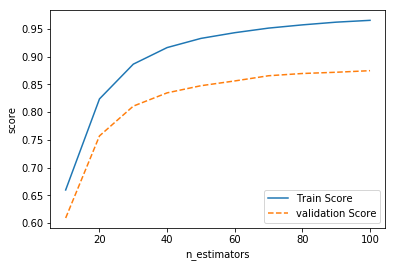

In [95]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, validation_score, linestyle = "--", label = "validation Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [96]:
# estimators 값을 50으로 지정하고 min_samples_leaf 값을 1~20까지 조정했을 때 train_score, validation_score 값 출력
train_score = []; validation_score =[]
para_leaf=[n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
  
  rf =GBR(random_state=8, n_estimators=50, min_samples_leaf = v_min_samples_leaf)
  rf.fit(df_train_x,df_train_y)
  
  train_score.append(rf.score(df_train_x,df_train_y))
  validation_score.append(rf.score(df_validation_x,df_validation_y))
  
df_score_leaf = pd.DataFrame()
df_score_leaf["min_samples_leaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["validationScore"]=validation_score
  
df_score_leaf.round(3)  

,min_samples_leaf,TrainScore,validationScore
0,1,0.933,0.848
1,2,0.931,0.848
2,3,0.933,0.845
3,4,0.931,0.848
4,5,0.931,0.849
5,6,0.931,0.848
6,7,0.929,0.847
7,8,0.925,0.844
8,9,0.924,0.845
9,10,0.921,0.840


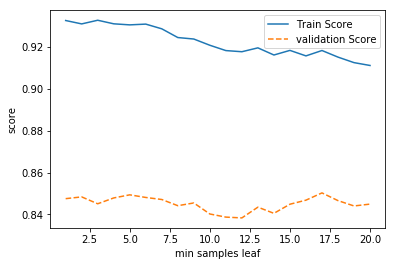

In [97]:
# 위의 값을 그래프로 출력
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, validation_score, linestyle = "--", label = "validation Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 MinSamplesLeaf 선정 = 17

In [98]:
# n_estimators=50, min_samples_leaf = 17로 고정하고 min_samples_split을 2~40으로 조정했을 때 train_score, validation_score 값 출력
train_score = []; validation_score =[]
para_split=[n_split * 2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
  
  gb =GBR(random_state=8, n_estimators=50, min_samples_leaf = 17, min_samples_split = v_min_samples_split)
  gb.fit(df_train_x,df_train_y)
  
  train_score.append(gb.score(df_train_x,df_train_y))
  validation_score.append(gb.score(df_validation_x,df_validation_y))
  
df_score_split = pd.DataFrame()
df_score_split["Estimators"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["validationScore"]=validation_score
  
df_score_split.round(3)  

,Estimators,TrainScore,validationScore
0,2,0.918,0.850
1,4,0.918,0.850
2,6,0.918,0.850
3,8,0.918,0.850
4,10,0.918,0.850
5,12,0.918,0.850
6,14,0.918,0.850
7,16,0.918,0.850
8,18,0.918,0.850
9,20,0.918,0.850


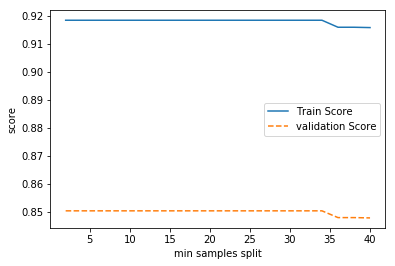

In [99]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, validation_score, linestyle = "--", label = "validation Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [100]:
# n_estimators=50, min_samples_leaf = 17, min_samples_split =34로 고정하고, max_depth를 1~10으로 조정했을 때 train_score, validation_score 값 출력

train_score = []; validation_score =[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
  
  gb =GBR(random_state=8, n_estimators=50, min_samples_leaf = 17, min_samples_split =34, max_depth = v_max_depth)
  gb.fit(df_train_x,df_train_y)
  
  train_score.append(gb.score(df_train_x,df_train_y))
  validation_score.append(gb.score(df_validation_x,df_validation_y))
  
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["validationScore"]=validation_score
  
df_score_depth.round(3)  

,Depth,TrainScore,validationScore
0,1,0.712,0.698
1,2,0.864,0.817
2,3,0.918,0.850
3,4,0.941,0.855
4,5,0.949,0.860
5,6,0.958,0.861
6,7,0.963,0.859
7,8,0.966,0.862
8,9,0.966,0.859
9,10,0.968,0.858


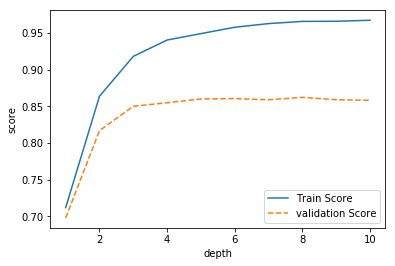

In [101]:
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, validation_score, linestyle = "--", label = "validation Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

In [102]:
# n_estimators=50, min_samples_leaf = 17, min_samples_split =34,
# max_depth = 3을 고정하고 learning_rate를 0.1~1까지 조정했을 떄 train_score, validation_score 값 출력
train_score = []; validation_score =[]

para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr :
  
  gb =GBR(random_state=8, n_estimators=50, min_samples_leaf = 17, min_samples_split =34, max_depth = 3, learning_rate = v_learning_rate)
  gb.fit(df_train_x,df_train_y)
  
  train_score.append(gb.score(df_train_x,df_train_y))
  validation_score.append(gb.score(df_validation_x,df_validation_y))
  
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"]=para_lr
df_score_lr["TrainScore"]=train_score
df_score_lr["validationScore"]=validation_score
  
df_score_lr.round(3)  

,LearningRate,TrainScore,validationScore
0,0.1,0.918,0.850
1,0.2,0.948,0.866
2,0.3,0.961,0.871
3,0.4,0.967,0.877
4,0.5,0.970,0.873
5,0.6,0.974,0.858
6,0.7,0.974,0.844
7,0.8,0.977,0.852
8,0.9,0.973,0.813


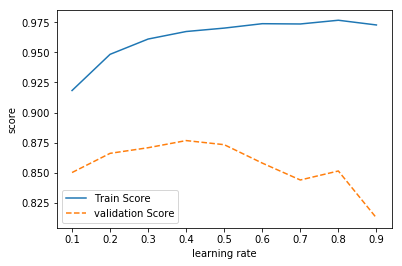

In [103]:
plt.plot(para_lr, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_lr, validation_score, linestyle = "--", label = "validation Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

In [104]:
# learning_rate = 0.4로 하여 최종 모델 생성

gb_final = GBR(random_state=8, n_estimators=40, min_samples_leaf = 17, min_samples_split =34, max_depth = 3, learning_rate = 0.4)
gb_final.fit(df_train_x,df_train_y)

# 최종 모델에 test set을 적용
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on validation set: {:.3f}".format(gb_final.score(df_validation_x, df_validation_y)))
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.962
Score on validation set: 0.874
Score on test set: 0.881


In [105]:
# 변수 중요도, AGE가 가장 높다.

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=gb_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.387
0,CEMENT,0.257
4,SUPERPLASTICIZER,0.153
3,WATER,0.083
6,FINE_AGGREGATE,0.056
1,BLAST_FURNACE_SLAG,0.052
5,COARSE_AGGREGATE,0.008
2,FLY_ASH,0.004


Text(0, 0.5, '변수')

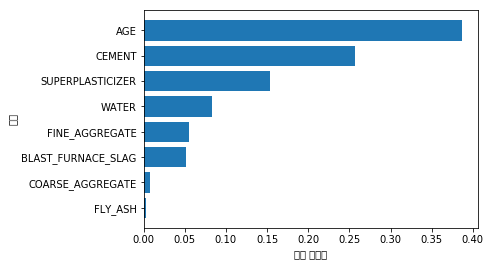

In [107]:
df_importance.sort_values("Importance",ascending = True, inplace = True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [108]:
#모델의 mse와 mae를 산출하여 비교
gb_final = GBR(random_state=8, n_estimators=40, min_samples_leaf = 4, min_samples_split =8, max_depth = 4, learning_rate = 0.3)
gb_final.fit(df_train_x,df_train_y)

gb_MAE = GBR(criterion="mae",random_state=8, n_estimators=40, min_samples_leaf = 4, min_samples_split =8, max_depth = 4, learning_rate = 0.3)
gb_MAE.fit(df_train_x, df_train_y)

# 예측값과 실제값의 비교
y_pred = gb_final.predict(df_train_x)
df_comparison = pd.DataFrame()
df_comparison["y_predicted"] = y_pred
df_comparison["y_real"]= df_raw_y

df_comparison.round(3)

,y_predicted,y_real
0,40.417,79.99
1,62.200,61.89
2,24.358,40.27
3,44.595,41.05
4,25.340,44.30
5,42.827,47.03
6,41.033,43.70
7,22.828,36.45
8,23.559,45.85
9,81.680,39.29


In [109]:
# 모델의 mse와 mae 
# MSE : 실제값과 예측값의 차이의 제곱
# 특이값이 존재하면 수치가 크게 증가한다.

# MAE : 실제값과 예측값의 차이의 절댓값
# 오류 지표를 실제 값과 유사한 단위로 다시 변환하여 해석을 쉽게 한다.
# 절대값을 취하기 때문에 가장 직관적으로 알 수 있는 지표이다.
# MSE 보다 특이치에 영향을 덜 받는다.
# 절대값을 취하기 때문에 모델이 실제보다 높은지 낮은지 알 수 없다.

mse = mean_squared_error(df_train_y, y_pred)
mae = mean_absolute_error(df_train_y, y_pred)
print("MSE :",mse.round(4))
print("MAE :",mae.round(4))

MSE : 4.3792
MAE : 1.465


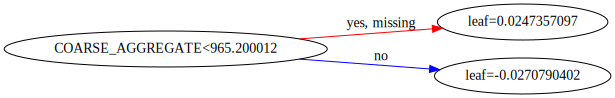

In [110]:
# 그래디언트 부스팅 개별 그래프 출력(0, 1, 2번)
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import to_graphviz
import matplotlib.pyplot as plt

model = XGBClassifier()
model.fit(df_train_x, df_train_y)
to_graphviz(model, fmap='', num_trees=0, rankdir='LR', yes_color='red', no_color='blue')

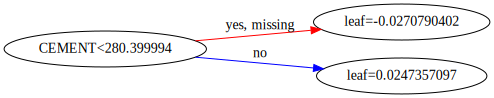

In [111]:
to_graphviz(model, fmap='', num_trees=1, rankdir='LR', yes_color='red', no_color='blue')

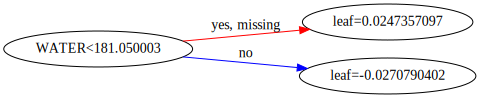

In [112]:
to_graphviz(model, fmap='', num_trees=10, rankdir='LR', yes_color='red', no_color='blue')

# 그래디언트 부스팅 모델 시각화 및 해석#

1.  트리에 영향이 큰 변수는 AGE, CEMENT, SUPERPLASTICIZER 등이다.

2. 첫 번째 트리에서 COARSE_AGGREGATE = 965.200012 값을 기준으로 True와 False로 나뉜다.

    두 번째 트리에서 CEMENT = 280.399994 값을 기준으로 True와 False로 나뉜다.

    열 번째 트리에서 WATER = 181.050003 값을 기준으로 True와 False로 나뉜다.


3. 그 이후에도 분리 조건을 만족하면 좌측, 만족하지 않으면 우측으로 내려가서 최종 리프를 찾는다.


4. 위의 그래디언트 부스팅 모델 도출 결과 학습 데이터로는 96.2%, validation 데이터로 parameter들을 조정한 결과 87.4%의 정확도를 보였다.


5. 또한 최종 test 데이터를 적용해봤을 때에 정확도는 88.1%로 다소 증가하였다.
  
  
#  의사결정트리, 랜덤 포레스트 모델과 비교
    1. 의사결정트리, 랜덤 포레스트 모델과 비교해 봤을 때 가장 비교적 높은 정확도를 가지고 있다.
2. 또한 두 모델과 비교했을 떄 MSE와 MAE 값이 현저히 낮다.
    MSE와 MAE는 실제값과 예측값과의 차로, 모델의 정확도를 측정할 수 있는 지표이다.
같은 데이터에 적용한 모델들의 각 값들은 크게 차이나며, 그래디언트 부스팅 모델이 상대적으로 그 값이 훨씬 작다.
따라서 그래디언트 부스팅 모델의 정확성이 두 모델보다 높다고 할 수 있다.
#

3. 그러나, 역시 건축물의 재료로 쓰이는 콘크리트의 강도를 측정할 때 쓰기에는 안전에 관련되어 있으므로 84.1%의 값도 신뢰성이 아주 높다고 할 수는 없다.
#
4. 따라서 다른 변수 값을 넣어 분석해서 신뢰성이 더 높은 모델을 도출하는 것이 좋다고 판단된다.
# 
    Score on training set: 0.962
    Score on validation set: 0.874
    Score on test set: 0.881

# **각 모델 별 MSE와 MAE 비교**

1. 랜덤 포레스트
    MSE : 25.8659
    MAE : 3.9118


2. 의사결정트리
    MSE : 50.1936
    MAE : 5.3067


3. 그래디언트 부스팅
    MSE : 4.3792
    MAE : 1.465